# Prendre en main l'API Python d'ArcGIS - épisode 1
## Administration d'utilisateurs et de groupes

Dans ce premier tutoriel de notre **[série de l'été consacrée à la prise en main de l'API Python d'ArcGIS](https://www.codethemap.fr/2024/05/prise-en-main-api-python-arcgis-intro.html)**, je vous propose de commencer par entamer le premier volet de capacités de l'API : l'organisation et l'administration du SIG. Cela comprend la gestion des utilisateurs, des groupes, des items et des serveurs.\
Dans ce premier tutoriel, nous allons nous concentrer sur l'automatisation de l'administration d'utilisateurs et de groupes et de leur contenu, en apprenant à ajouter et supprimer des utilisateurs et transférer le contenu d'un utilisateur supprimé, créer des groupes, ajouter des utilisateurs dans des groupes etc.\
Notez que vous aurez pour cela besoin d'un **compte administrateur** dans votre organisation. 

### 1/ Connexion au GIS

A adapter selon votre environnement et votre méthode d'authentification. [Voir l'aide en ligne pour plus d'informations](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/).  
La cellule va peut-être vous renvoyer un message rouge pour vous prévenir que vous êtes connectés en tant qu'adminisatrateur, et qu'il faut faire attention aux opérations que vous utilisez. Cela n'empêche pas votre code de s'exécuter correctement.

In [1]:
from arcgis.gis import GIS
gis = GIS("home")

/opt/conda/lib/python3.9/site-packages/arcgis/gis/__init__.py:703: UserWarning: You are logged on as plouis_esrifrance with an administrator role, proceed with caution.
  warnings.warn(


#### Alternative si votre environnement n'est pas directement connecté à votre portail

In [ ]:
#à modifier avec vos propres informations d'authentification et l'url de votre portail
gis = arcgis.gis.GIS(
url="https://url.devotre.org/portal",
username="nom_utilisateur",
password="motdepasse"
)

### 2/ Ajouter des utilisateurs à votre portail depuis un fichier CSV

#### Lecture du CSV en tant que dataframe pandas

Les [DataFrames pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) permettent de gérer les données tabulaires de manière très efficace dans Python. Nous allons donc transformer nos données csv en pandas dataframe. Pour cela, il faut importer la bibliothèque tierce pandas puis utiliser sa fonction `read_csv()`

In [2]:
import pandas as pd #import de la bibliothèque.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/JapaLenos/Python-in-ArcGIS/main/Prise-en-main-API-Python/Tuto1-admin-utilisateurs-groupes/nouveaux-utilisateurs-org-arcgis.csv',sep=";")
#remplacer par le lien de votre propre fichier csv si nécessaire
df #permet d'afficher le résultat de manière interactive dans un Notebook

,Prenom,Nom,Email,Role,Type d'utilisateur
0,Jean,Dupont,Jean.Dupont@domaine.ext,user,creator
1,Anne,Fleury,Anne.Fleury@domaine.ext,user,creator
2,Marie,Martin,Marie.Martin@domaine.ext,publisher,GISProfessionalAdv
3,Camille,Petit,Camille.Petit@domaine.ext,user,creator
4,Philippe,Lambert,Philippe.Lambert@domaine.ext,publisher,creator
5,Daniel,Schneider,Daniel.Schneider@domaine.ext,user,GISProfessionalAdv


#### Itérer dans la liste des utilisateurs et les ajouter au portail

Pour ajouter les utilisateurs au portail, nous allons utiliser la fonction `create()` de la classe [`UserManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#usermanager) de l'API.  
Vous retrouverez la doc de cette classe ici : https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#usermanager

##### Comprendre la fonction gis.users.create()

Voici la description de la fonction dans la doc :  
`create(username, password, firstname, lastname, email, role, description=None, provider='arcgis', idp_username=None, level=2, thumbnail=None, user_type=None, credits=- 1, groups=None, email_text=None)`  
Nous allons renseigner les paramètres utiles. Pour savoir à quoi sert quel paramètre, vous pouvez consulter la [documentation de la classe `UserManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#usermanager), ou bien exécuter la cellule ci-dessous :

In [ ]:
gis.users.create?

Pour chaque fonction de l'API Python d'ArcGIS, vous pouvez accéder à la doc sans sortir de votre IDE en ajoutant un `?` à la fin du nom complet de la fonction.

La fonction vous demande notamment de renseigner le rôle et le type d'utilisateur du nouvel utilisateur que vous souhaitez inscrire dans votre organisation. Si besoin, vous pouvez savoir quels rôles et types d'utilisateurs sont disponibles au sein de votre organisation en exécutant les deux cellules ci-dessous :

In [ ]:
#connaître les rôles disponibles dans votre org : 
for org_role in gis.users.roles.all():
        print(f"{org_role.name:25}{org_role.role_id}")

In [ ]:
#connaître les types d'utilisateurs disponibles dans votre org :
for utype in gis.users.license_types:
        print(f"{utype['id']}")

##### Utiliser la fonction gis.users.create()

Nous allons parcourir chacun des utilisateurs du dataframe (le tableau importé juste avant) avec une boucle d'itération for. Pour chaque itération, nous allons utiliser la fonction `create()` en allant récupérer les valeurs du tableau pour renseigner les paramètres de la fonction.\
`df["element_entete"][i]` permet d'aller récupérer l'information qui se trouve dans la colonne "element_entete" (par exemple dans notre dataframe : "Prenom")et dans la ligne i. A la première itération de la boucle, i aura une valeur de 0, puis de 1 à la deuxième itération, etc. jusqu'à avoir parcouru la totalité des lignes du tableau.

In [6]:
for i in df.index: #itération dans le tableau des nouveaux utilisateurs
    nom_utilisateur = '{0}_{1}'.format(df["Prenom"][i],df["Nom"][i])
    
#la méthode .format() ici permet d'intégrer des variables au sein d'une chaine de caractère. 
#{0} et {1} dans la chaîne de caractère servent d'emplacement réservé pour les 2 variables qui sont ensuite appelées dans le .format()
#cette méthode sera très utilisée dans les tutoriels, rendez-vous dans la doc pour mieux la comprendre : https://www.w3schools.com/python/ref_string_format.asp
    
    if len(gis.users.search(query='username:'+ nom_utilisateur))==0: #vérifie que l'utilisateur n'existe pas déjà dans l'org
        nouvel_utilisateur = gis.users.create(username = nom_utilisateur, 
                              password = 'passw*rd',
                              firstname = df["Prenom"][i],
                              lastname = df["Nom"][i],
                              email = df["Email"][i],
                              role = "org_{0}".format(df["Role"][i]),
                              user_type = "{0}UT".format(df["Type d'utilisateur"][i])
                              )
        display(nouvel_utilisateur)
    else :
        print("l'utilisateur {} existe déjà".format(nom_utilisateur))

<User username:Jean_Dupont>

<User username:Anne_Fleury>

<User username:Marie_Martin>

<User username:Camille_Petit>

<User username:Philippe_Lambert>

<User username:Daniel_Schneider>

### 3/ Désactiver ou supprimer un utilisateur et transférer son contenu

#### Accéder à l'utilisateur à supprimer 

Pour accéder à un utilisateur, nous allons utiliser la fonction `get()` de la classe [`UserManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#usermanager) de l'API

In [9]:
utilisateur_suppr = gis.users.get("Jean_Dupont")
utilisateur_suppr

<User username:Jean_Dupont>

#### Supprimer l'utilisateur et réassigner son contenu

Nous allons pour cela utiliser la fonction `delete` de la classe [`User`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#user)

In [ ]:
utilisateur_suppr.delete?

La fonction `delete` nous permet de tirer parti du paramètre `reassign_to`, qui nous permet de transférer le contenu de l'utilisateur supprimé à un autre utilisateur. Je vais donc accéder à un autre utilisateur pour lui transférer le contenu.  
J'aurais pu transférer le contenu à mon propre profil en indiquant `gis.users.me`.

In [10]:
utilisateur_suppr.delete(reassign_to = gis.users.get("Anne_Fleury"))

True

Notez que si vous souhaitez réassigner un contenu sans supprimer un utilisateur, vous pouvez utiliser la fonction `reassign_to` de la classe [`Item`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#item)

### 3bis/ Supprimer par lots tous les viewers inactifs de votre portail

Maintenant que nous savons supprimer des utilisateurs, nous pouvons nous en servir par exemple pour supprimer tous les utilisateurs de type viewer inactifs de notre portail.

#### Rechercher tous les viewers du portail

Pour rechercher les viewers, nous allons utiliser la fonction `search()` de la classe [`UserManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#usermanager) de l'API

In [ ]:
viewers = gis.users.search(max_users=1000, user_type="viewer")
#la limite d'utilisateur retournés (ici 1000, par défaut 100) est modifiable avec l'argument max_users
#Les réponses sont limitées à 10 000 résultats par requête
viewers

#### Création d'une liste de viewers à conserver

Si vous savez que certains utilisateurs particuliers doivent être conservés, vous pouvez créer une liste avec le nom de ces utilisateurs : 

In [ ]:
a_conserver = ['viewer_esrifrance'] #entrer les noms des utilisateurs ne devant pas être supprimés même s'ils rencontrent tous les autres critères 

#### Itération dans la liste et vérification de l'inactivité du viewer avant suppression

Nous pouvons maintenant itérer dans la liste de tous nos viewers. Nous utilisons la propriété `lastLogin` de la classe [`User`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#user) pour vérifier que le viewer est bien inactif. Vous pouvez si vous le souhaitez rajouter d'autres conditions de suppression basées sur d'autres propriétés de cette classe.

In [ ]:
for viewer in viewers:
    if viewer.username not in a_conserver : #vérifie que le viewer n'est pas dans la liste des utilisateurs à conserver
        if viewer.lastLogin >= -1: #-1 signifie "jamais connecté". Il est possible de donner une date de dernière connexion en epcoh MILISECONDE (epoch converter : https://www.epochconverter.com/)
            print("suppression de l'utilisateur: " + viewer.username)
            #viewer.delete() 

#il est conseillé de faire tourner une première fois cette cellule telle quelle. Cela imprime la liste des utilisateurs sans la supprimer. 
#Parcourez-la avant d'enlever le commentaire de la ligne viewer.delete() et de réellement supprimer les utilisateurs.

Notez que sans itération, il est également possible de supprimer en lot une liste d'utilisateurs avec la fonction `delete_users()` de la classe [`UserManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#usermanager)

#### Supprimer les utilisateurs tests de la démo

Nous allons maintenant supprimer les utilisateurs ayant servi pour cette démo pour qu'ils n'encombre pas votre portail

In [11]:
for i in df.index: #itération dans le tableau des nouveaux utilisateurs
    try :
        suppr = gis.users.get(username = '{0}_{1}'.format(df["Prenom"][i],df["Nom"][i]))
        if suppr != None : #permet de passer si l'utilisateur a déjà été supprimé
            suppr.delete()
            print ("L'utilisateur {0} {1} a été supprimé".format(df["Prenom"][i],df["Nom"][i]))
    except:
        print("An exception occurred") 

L'utilisateur Anne Fleury a été supprimé
L'utilisateur Marie Martin a été supprimé
L'utilisateur Camille Petit a été supprimé
L'utilisateur Philippe Lambert a été supprimé
L'utilisateur Daniel Schneider a été supprimé


### 4/ Automatiser la gestion des groupes (création, inscription d'utilisateurs)

#### Création des groupes

De la même manière que nous avons pu utiliser l'API pour ajouter des utilisateurs par lot, nous allons pouvoir créer des groupes dans notre org à partir d'un fichier csv. Pour cela, nous utiliserons la fonction `create()` de la classe [`GroupManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#groupmanager). Comme tout à l'heure, nous commencerons par transformer le csv en dataframe pandas, que nous parcourons ensuite avec une boucle for pour créer les groupes les uns après les autres.

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/JapaLenos/Python-in-ArcGIS/main/Prise-en-main-API-Python/Tuto1-admin-utilisateurs-groupes/nouveaux-groupes-org-arcgis.csv',sep=";")
#remplacer par le lien de votre propre fichier csv si nécessaire
df #permet d'afficher le résultat de manière interactive dans un Notebook

,titre,tags,description,resume,acces,miniature,isInvitationOnly,isViewOnly
0,Tuto API Python - Applications à la une,"applications, page d'accueil",Ce groupe contient les applications qui sont a...,Applications qui apparaissent sur la page d'ac...,org,https://raw.githubusercontent.com/JapaLenos/Py...,True,True
1,Tuto API Python - Cartes et applications publi...,"cartes, applications, partage, public",Ce groupe contient une collection de cartes et...,Applications et cartes partagées au grand public,public,https://raw.githubusercontent.com/JapaLenos/Py...,False,False
2,Tuto API Python - Contenu démos direction des ...,"DSOL, direction des solutions, démos, démo",Ce groupe contient des démonstrations et des d...,Démonstrations des produits du système ArcGIS,private,https://raw.githubusercontent.com/JapaLenos/Py...,True,False
3,Tuto API Python - Template d'apps web,"apps, web, template",Ce groupe contient une collection de templates...,Templates d'applications web,org,https://raw.githubusercontent.com/JapaLenos/Py...,False,False


In [ ]:
#doc de la fonction
gis.groups.create?

<Group title:"Tuto API Python - Applications à la une" owner:plouis_esrifrance>
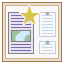

<Group title:"Tuto API Python - Cartes et applications publiques" owner:plouis_esrifrance>
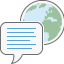

<Group title:"Tuto API Python - Contenu démos direction des solutions" owner:plouis_esrifrance>
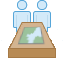

<Group title:"Tuto API Python - Template d'apps web" owner:plouis_esrifrance>
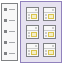

In [20]:
for i in df.index:
    if len(gis.groups.search(query='title:'+df["titre"][i]))==0: #vérifie que le groupe n'existe pas encore
        nouveau_groupe = gis.groups.create(title = df["titre"][i],
                              tags = df["tags"][i],
                              description = df["description"][i],
                              snippet = df["resume"][i],
                              access = df["acces"][i],
                              thumbnail = df["miniature"][i],
                              is_invitation_only = df["isInvitationOnly"][i],
                              is_view_only = df["isViewOnly"][i])
        display(nouveau_groupe)
    else :
        print("Le groupe {0} existe déjà".format(df["titre"][i]))

#### Ajouter des utilisateurs dans les groupes

Je veux maintenant faire en sorte d'ajouter tous les membres de mon organisation appartenant à la catégorie "Direction des solutions" au groupe de contenus partagés pour l'équipe de la direction des solutions.   
Pour cela, vous devez avoir défini des catégories dans votre org (disponible dans ArcGIS Online, et depuis la v11.1 d'ArcGIS Enterprise) et les avoir attribuées au membre de votre organisation. Plus d'infos dans [cette doc](https://doc.arcgis.com/fr/arcgis-online/administer/manage-members.htm) sous le chapitre "Classer les membres".  
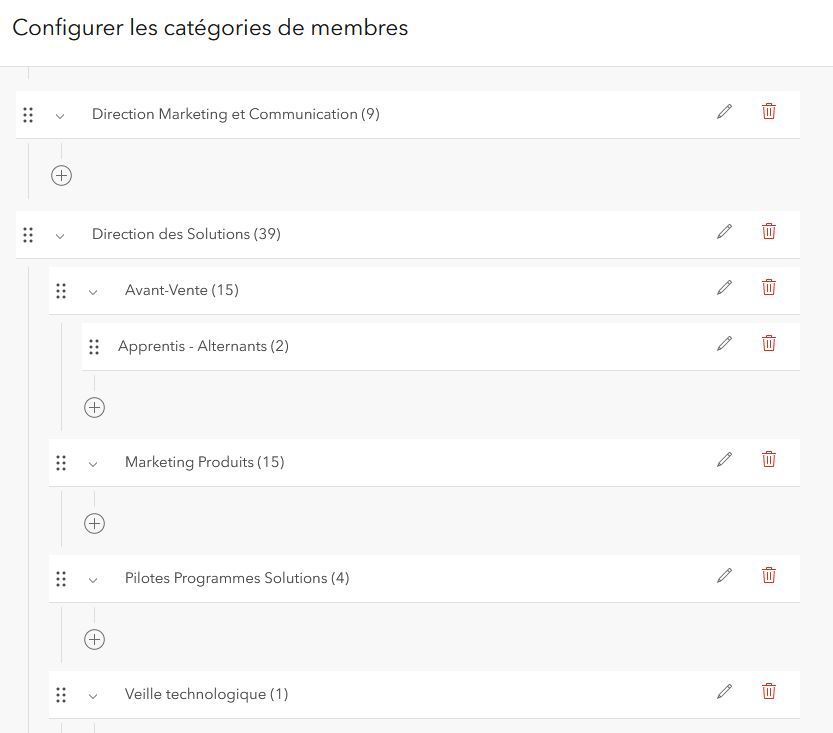

Je commence par accéder à la liste de tous les utilisateurs de mon org appartenant à la catégorie "Direction des Solutions" (à adapter selon les catégories de votre org) avec la fonction `search()` de la classe [`UserManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#usermanager) de l'API. 

In [ ]:
dsol = gis.users.search('categories:"Direction des Solutions"') #je cherche spécifiquement les membres de mon org appartenant à la catégorie "Direction des Solutions"
#à remplacer par l'une des catégories de membres de votre org 
#attention, Python est sensible à la casse, respectez-donc scrupuleusement les min et maj
dsol

J'accède ensuite au groupe contenant les démos partagées avec la fonction `search()` de la classe [`GroupManager`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#groupmanager) de l'API :

In [ ]:
groupe_demo = gis.groups.search('title: Tuto API Python - Contenu démos direction des solutions ')[0]
groupe_demo

Je récupère la liste des inscrits dans ce groupe avec la fonction `get_members()` de la classe [`Group`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#groupmanager) de l'API

In [ ]:
membres = groupe_demo.get_members()
membres

Je vais ensuite itérer parmi tous les utilisateurs de la catégorie Direction des Solutions récupérés précédemment, vérifier s'ils sont déjà membres du groupe, les ajouter à une liste s'ils ne le sont pas, puis ajouter tous les membres de cette liste au groupe avec la fonction `add_users()` de la classe [`Group`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#groupmanager) de l'API.

In [ ]:
membres_a_ajouter = []
for utilisateur in dsol :
    #je vérifie que l'utilisateur ne soit pas déjà membre du groupe
    #un membre peut être admin, user ou owner, je vérifie donc qu'il n'est aucun des trois
    #pour cela, je compare son nom d'utilisateur aux membres du groupe 
    est_membre = (utilisateur.username in membres['users'] or 
                  utilisateur.username in membres['admins'] or 
                  utilisateur.username == membres['owner'])
    if not est_membre :
        membres_a_ajouter.append(utilisateur) #j'ajoute l'utilisateur à la liste des personnes à inscrire au groupe s'il n'est pas membre
groupe_demo.add_users(membres_a_ajouter) #j'incris tous les utilisateurs de la liste au groupe

Je peux maintenant réutiliser la fonction `get_members()` pour vérifier que les utilisateurs ont bien été rajoutés au groupe :

In [ ]:
membres = groupe_demo.get_members()
membres

L'API permet également de retirer les membres d'un groupe avec la fonction `remove_users()`. Nous allons l'utiliser ici par exemple pour retirer tous les utilisateurs dont le nom d'utilisateur commence par un "a" (oui, c'est complètement arbitraire).
Notez qu'il n'est pas possible de supprimer le propriétaire ("owner") du groupe.

In [ ]:
membres_a_retirer=[]
for utilisateur in membres['users'] : #je parcoure la liste des utilisateurs du groupe récupérés dans la cellule précédente :
    if utilisateur[0] =="a" :
        membres_a_retirer.append(utilisateur)
groupe_demo.remove_users(membres_a_retirer)

Je peux à nouveau vérifier que tout s'est bien passé :

In [ ]:
membres = groupe_demo.get_members()
membres

Maintenant que nous savons créer des groupes et y inscrire des utilisateurs, il serait bien de pouvoir y partager du contenu non? Cette fonctionnalité est disponible dans l'API Python, mais nous le verrons dans un autre tutoriel de cette série, qui sera consacré à la création, à la publication et au partage du contenu dans votre SIG web. Pour ajourd'hui, nous nous contenterons de supprimer ces groupes de démo pour ne pas encombrer votre organisation.

#### Suppression des groupes

In [21]:
for i in df.index:
    titre = df["titre"][i]
    try :
        suppr = gis.groups.search('title:{0}'.format(titre))
        if len(suppr) > 0 : #permet de passer si le groupe a déjà été supprimé
            suppr[0].delete()
            print("Le groupe {0} a été supprimé".format(titre))
        else :
            print("Le groupe {0} n'existe pas".format(titre))
    except:
        print("An exception occurred") 

Le groupe Tuto API Python - Applications à la une a été supprimé
Le groupe Tuto API Python - Cartes et applications publiques a été supprimé
Le groupe Tuto API Python - Contenu démos direction des solutions a été supprimé
Le groupe Tuto API Python - Template d'apps web a été supprimé
